# Sentiment analysis

# Imports

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('./data/data_JV_2020_2023_tokenised.csv')

In [30]:
df['title_y'] = df['title_y'].fillna('')
#df2 = df[df['title_y'].str.contains('Cyberpunk')].copy()
df2 = df.iloc[:10000,:].copy()

In [31]:
df2.shape

(10000, 11)

# Data preprocessing

In [32]:
ps = PorterStemmer()

def stem_word(word):
    return ps.stem(word)

def stem_column(column):
    return column.apply(lambda x: ' '.join([stem_word(word) for word in nltk.word_tokenize(x)]))

def remove_stop_words(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))  
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


df2['text'] = df2['text'].fillna('')
df2["avis_stopwords"] = df2["text"].apply(remove_stop_words)
df2["avis_preprocess"] = stem_column(df2["avis_stopwords"])

# Modelisation (transfer learning)

In [35]:
MODEL_NAME = "LiYuan/amazon-review-sentiment-analysis"
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MODEL = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, from_tf = False)

sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=TOKENIZER)

In [36]:
#df2 = df.iloc[:5000,:].copy()

In [181]:
def get_sentiment(text):
    
    max_length = 512
    text = text[:max_length]
    result = sentiment_task(text)[0]
    
    return result["label"]

df2['sentiment_HF'] =df2['avis_preprocess'].apply(get_sentiment)
# pour 5k lignes ca prend 13min donc pour 600k lignes ca prendra environ 7h

In [182]:
df2['sentiment_HF'] = df2['sentiment_HF'].apply(lambda x : x[0])
df2['sentiment_HF'] = df2['sentiment_HF'].astype('int')

# Evaluation performances

In [183]:
df2['rating']=df2['rating'].astype('int')

In [184]:
df2[['sentiment_HF','rating']]

,sentiment_HF,rating
0,5,4
1,4,5
2,5,5
3,5,5
4,5,1
...,...,...
9995,5,5
9996,5,5
9997,1,1
9998,2,5


In [185]:
df2['sentiment_pred'] = df2['sentiment_HF'].apply(lambda x : 1 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3)
df2['sentiment_true'] = df2['rating'].apply(lambda x : 1 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3)
df2['perf_count'] = df2.apply(lambda row: 1 if row['sentiment_pred'] == row['sentiment_true'] else 0, axis=1)


In [203]:
df2.iloc[:500,:]

,Unnamed: 0,rating,title_x,text,parent_asin,title_y,main_category,text_tokenized,store,details,timestamp,avis_stopwords,avis_preprocess,sentiment_HF,sentiment_pred,sentiment_true,perf_count
0,0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,B07DK1H3H5,Cyberpunk 2077 - PC [Game Download Code in Box],Video Games,"['i', '’', 'm', 'playing', 'on', 'ps', '##5', ...",WARNER BROS,"{'Release date': 'December 10, 2020', 'Best Se...",2020-12-17 07:33:24.795,"’ playing ps5 ’ interesting . ’ unique , massi...","’ play ps5 ’ interest . ’ uniqu , massiv , nea...",5,3,3,1
1,1,5,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,B07SRWRH5D,Final Fantasy VII: Remake - PlayStation 4,Video Games,"['nos', '##tal', '##gic', 'fun', '.', 'a', 'bi...",Square Enix,"{'Release date': 'April 10, 2020', 'Best Selle...",2020-04-16 17:31:54.941,Nostalgic fun . bit slow . hope ’ stretch far ...,nostalg fun . bit slow . hope ’ stretch far . ...,4,3,3,1
2,2,5,Will use again,Instant delivery!,B004RMK57U,Playstation Plus: 3 Month Membership [Digital ...,Video Games,"['instant', 'delivery', '!']",PlayStation,"{'Release date': 'March 22, 2011', 'Pricing': ...",2020-10-17 14:28:29.361,Instant delivery !,instant deliveri !,5,3,3,1
3,4,5,Price bumps it up from 4 stars,*it fits TWO wired Retro-bit 6 button controll...,B08L6782X9,Aenllosi Hard Carrying Case Compatible with Se...,Video Games,"['*', 'it', 'fits', 'two', 'wired', 'retro', '...",Aenllosi,{'Pricing': 'The strikethrough price is the Li...,2021-05-19 20:24:30.253,* fits TWO wired Retro-bit 6 button controller...,* fit two wire retro-bit 6 button control . ye...,5,3,3,1
4,5,1,It's an Auto-renew scam,Sony and Amazon are collaborating in an Auto-r...,B017V6YVDC,PlayStation Plus: 1 Month Membership [Digital ...,Video Games,"['sony', 'and', 'amazon', 'are', 'collaboratin...",PlayStation,"{'Release date': 'November 11, 2015', 'Pricing...",2020-12-12 01:54:34.794,Sony Amazon collaborating Auto-renew scam < br...,soni amazon collabor auto-renew scam < br / > ...,5,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1150,4,"Setting hard, but covers great",Not gona lie... was a little tough lining up. ...,B0728CRKP2,"Nintendo 2DS XL Screen Protector Pack, amFilm ...",Video Games,"['not', 'go', '##na', 'lie', '.', '.', '.', 'w...",amFilm,"{'Best Sellers Rank': {'Video Games': 14435, '...",2021-01-01 19:42:26.354,gona lie ... little tough lining . Even harder...,gona lie ... littl tough line . even harder ke...,5,3,3,1
496,1152,4,Lor,Love the game. The case came broken on a bott...,B00WOK8YX4,Middle Earth: Shadow of Mordor Game of the Yea...,Video Games,"['love', 'the', 'game', '.', 'the', 'case', 'c...",Warner Manufacturing,"{'Release date': 'May 5, 2015', 'Best Sellers ...",2020-06-22 11:38:19.096,Love game . case came broken bottom corner . L...,love game . case came broken bottom corner . l...,5,3,3,1
497,1153,4,If you love LOTR then it's worth it,"Haven't played this one yet, but Im a huge LOT...",B06XBN6NCH,Middle-Earth: Shadow Of War - PlayStation 4,Video Games,"['haven', ""'"", 't', 'played', 'this', 'one', '...",WB Games,"{'Release date': 'October 10, 2017', 'Best Sel...",2020-06-22 11:35:39.135,"n't played one yet , Im huge LOTRs fan. < br /...","n't play one yet , im huge lotr fan . < br / >...",1,1,3,0
498,1154,5,Good carry case,Bought this for my daughter. It keeps her gam...,B01N31YZJV,Soyan Carrying Case for Nintendo New 3DS XL an...,Video Games,"['bought', 'this', 'for', 'my', 'daughter', '....",Soyan,{'Pricing': 'The strikethrough price is the Li...,2020-06-22 11:17:51.284,Bought daughter . keeps game safe allowing lit...,bought daughter . keep game safe allow littl e...,5,3,3,1


In [186]:
print(f"Performance : {round(df2['perf_count'].sum()/df2.shape[0]*100,2)}% de bonnes predictions")

Performance : 82.71% de bonnes predictions


# Récuperation des mots responsables des bons sentiments

In [187]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialiser l'analyseur de sentiments
sia = SentimentIntensityAnalyzer()

# Fonction pour extraire les mots les plus fréquents des commentaires positifs
def mots_positifs(commentaires):
    mots_positifs = []
    mots_a_exclure = ['br', 'game','great','like','playing','one','good','games','play','love','get','well','really','would','time','use',
                      'nice','also','nice','even','much','playing','case','got','loves','played']
    
    for commentaire in commentaires:
        if sia.polarity_scores(commentaire)['compound'] > 0:
            mots = [mot.lower() for mot in word_tokenize(commentaire) if mot.isalpha() and mot.lower() not in stopwords.words('english') and mot.lower() not in mots_a_exclure]
            mots_positifs.extend(mots)
            
    return mots_positifs

# Extraire les mots les plus fréquents dans les commentaires positifs
mots_freq_positifs = FreqDist(mots_positifs(df2[df2['sentiment_pred'] == 3]['text']))
mots_freq_negatifs = FreqDist(mots_positifs(df2[df2['sentiment_pred'] == 1]['text']))

In [188]:
print("Les mots les plus fréquentsµ associés aux commentaires positifs :")
for mot, freq in mots_freq_positifs.most_common(200):
    print(f"{mot}: {freq}")

Les mots les plus fréquentsµ associés aux commentaires positifs :
controller: 1312
fun: 1044
switch: 963
original: 823
new: 713
story: 708
works: 687
easy: 609
first: 597
still: 572
better: 545
little: 517
lot: 515
bought: 506
feel: 499
best: 498
price: 484
back: 468
way: 463
perfect: 444
make: 441
hours: 438
could: 433
controllers: 429
old: 425
work: 421
quality: 419
buy: 418
graphics: 415
son: 410
want: 405
recommend: 391
pretty: 389
characters: 380
xbox: 379
buttons: 373
worth: 372
made: 368
bit: 365
far: 364
gift: 354
go: 350
long: 349
nintendo: 347
know: 346
definitely: 342
feels: 342
different: 342
headset: 341
system: 340
product: 339
think: 338
since: 338
remake: 338
though: 335
amazing: 332
kids: 329
series: 325
loved: 322
many: 320
used: 314
happy: 311
every: 311
super: 310
looks: 310
part: 307
need: 306
everything: 299
gameplay: 297
right: 295
put: 294
came: 293
say: 288
fit: 286
awesome: 284
see: 283
hard: 282
things: 279
using: 276
gaming: 275
thing: 272
makes: 270
look: 2

In [189]:
print("Les mots les plus fréquents associés aux commentaires positifs :")
for mot, freq in mots_freq_negatifs.most_common(200):
    print(f"{mot}: {freq}")

Les mots les plus fréquents associés aux commentaires positifs :
controller: 180
original: 168
story: 118
work: 117
first: 107
better: 104
could: 103
new: 100
back: 99
buy: 92
never: 82
way: 81
know: 78
make: 78
still: 77
hours: 73
want: 73
remake: 73
people: 70
go: 70
going: 70
money: 68
amazon: 67
feel: 67
little: 66
bought: 65
need: 63
bad: 63
ca: 63
characters: 63
system: 61
xbox: 60
think: 58
switch: 58
product: 57
many: 56
part: 56
controllers: 55
see: 54
years: 53
actually: 53
buttons: 52
headset: 51
lot: 51
say: 51
bit: 50
right: 50
without: 50
since: 50
nothing: 49
another: 48
used: 48
around: 47
though: 46
graphics: 46
return: 46
price: 46
every: 46
months: 46
times: 46
fun: 45
things: 45
quality: 45
far: 45
star: 45
tried: 44
long: 44
two: 44
find: 44
reviews: 44
pc: 44
sure: 44
quite: 44
character: 43
works: 43
look: 43
pretty: 43
thing: 43
come: 42
put: 42
anything: 42
old: 42
review: 41
take: 41
next: 41
different: 41
left: 40
made: 40
feels: 40
something: 40
hard: 40
get

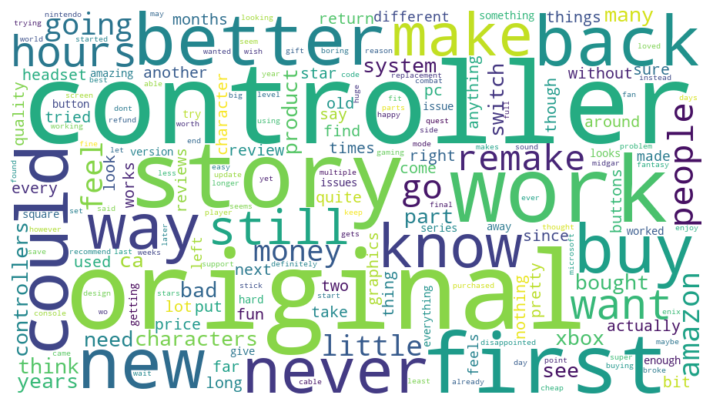

In [190]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Créer l'objet WordCloud
wordcloud = WordCloud(width=900, height=500, background_color='white').generate_from_frequencies(mots_freq_negatifs)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Champs lexicaux

In [191]:
# a utiliser aves les sentiments positifs
categories_bonnes = {
    'graphismes': ['graphism','graphics','graphic','look','visuals','art','design','aesthetics','rendering','resolution','detail','texture','animation'],
    'gameplay': ['gameplay','combat','fight','experience','mechanics','controls','interaction','challenge','pace','flow','depth','strategy','tactics'],
    'enfants': ['kids','kid','son','daughter','sons','daughters','children','child','young ones','offspring','little ones','family'],
    'musiques_sons': ['headset','music','musics','sound','sounds','audio','ambient','score','tracks','effects','voiceover','dialogue'],
    'bon_scenario_histoire': ['story','characters','character','feel','feelings','feels','narrative','plot','lore','world-building','dialogue','twists','development'],
    'se_joue_avec_manette': ['controller','controllers','gamepad','joystick','input device','remote','pad','analog stick','d-pad','motion controls'],
    'open_world': ['open','liberty','freedom','sandbox','exploration','non-linear','vast','expansive','immersive','world design','environment','map size','boundless'],
    'jeu_facile': ['easy','accessible','simple','casual','beginner-friendly','user-friendly','approachable','undemanding','relaxed'],
    'jeu_faisant_partie_dune_saga': ['first','better','improved','sequel','prequel','series','franchise','installment','continuation','universe','lore','canon'],
    'jeu_original': ['original','new','innovative','unique','fresh','creative','novel','groundbreaking','distinctive','trailblazing','avant-garde'],
    'rapport_qualite_prix': ['price','prices','worth','quality','works','buy','bought','value','affordable','cost-effective','investment','budget-friendly','expensive'],
    'jeu_fun': ['fun','happy','enjoyable','entertaining','amusing','joyful','lighthearted','delightful','cheerful','playful','upbeat','spirited'],
    'jeu_sombre': ['sad','tears','dead','death','depressing','bleak','gloomy','tragic','grim','morbid','melancholic','dark'],
    'jeu_dur': ['hard','hardcore','difficult','though','challenging','punishing','demanding','intense','grueling','tough','unforgiving','steep']
}

# a utiliser aves les sentiments negatifs
categories_mauvaises = {
    'jeu_bug': ['bugs','bug','glitch','glitches','errors','crashes','issues','problems','flaws','defects'],
    'mauvais_gameplay': ['gameplay','combat','fight','experience','mechanics','controls','interaction','challenge','pace','flow','depth','strategy','tactics'],
    'jeu_trop_volumineux' : ['gb','GB','giga','gigas','go','GO','Gb','gig','Gig','download','Download','update','install'],
    'jeu_trop_cher' : ['price','prices','worth','quality','works','buy','bought','value','affordable','cost-effective','investment','budget-friendly','expensive','money','cost','costs'],
    'mauvais_graphismes' : ['graphism','graphics','graphic','look','visuals','art','design','aesthetics','rendering','resolution','detail','texture','animation']    
}


# Part de categorie par jeu

In [192]:
df[df['title_y'].str.contains('Call of Duty: Modern Warfare')][['parent_asin','title_y']].value_counts()

parent_asin  title_y                                                                                                                                            
B07SNN8GV5   Call of Duty: Modern Warfare Battle Pass Edition - [Xbox One Digital Code]                                                                             538
B0CCZWKKV3   Call of Duty: Modern Warfare II - PlayStation 5                                                                                                        172
B07SD542FN   KontrolFreek Call of Duty: Modern Warfare - A.D.S. Performance Thumbsticks for Xbox One Controller | 2 High-Rise, Concave | Transparent/Black           73
B07S8XXCVD   KontrolFreek Call of Duty: Modern Warfare - A.D.S. Performance Thumbsticks for PlayStation 4 (PS4) | 2 High-Rise, Concave | Transparent/Black           70
B074CB2RNQ   Call of Duty: Modern Warfare Remastered - Xbox One                                                                                                      63

In [193]:
dico_jeux_exemple = {'Cyberpunk' : ['B07DK1H3H5','B07SMBK245','B07TJ5Z389','B07S7RQST5'],
                     'The witcher 3' : ['B07Z9Z39ZW','B087T1FS9K','B00DE88BU6','B01FUCV5K6','B00L4SD1F8','B01L0TM25U','B07SZJQM7P','B0045Y2IVQ','B07J2MQZK5','B00FUC6SZO','B0858VSZCW','B0BRNZRPSH','B01L26C0US','B07X3ZWL7X','B00ICWO1XA','B07X6JP2QF','B00WRJCRP8','B074MY5TN6','B0BRNY8987','B01DDRA9UW','B00WV7PT9W','B01B4YOBDM'],
                     'Fifa22' : ['B089GGLKHQ','B08KJPPBQK','B08J27JV17','B08BMTDPLG','B08J2BPWGS','B08J2454R3','B08HWGBNLJ','B08BP3XFNH','B08B9Z6573','B08BMVN1PZ','B08J248GXK','B08NDRGH4K','B08J28WVHL','B08J2HDGKX','B08KTHWR1D','B08KXSFFJ6','B08GPQQTX1','B09486H473'],
                     'Call of Duty: Modern Warfare' : ['B07SNN8GV5','B074CB2RNQ','B07ZNVGJS1']
                     }

In [194]:
#df[df['title_y'].str.contains('Mario Bros')]['parent_asin'].value_counts()

In [195]:
#df[df['parent_asin']=='B08F97Q8HS']

In [205]:
def calculate_prop_adj_jeu(jeu,cat,sentiment):
    parent = dico_jeux_exemple[jeu]
    df_temp = df2[df2['parent_asin'].isin(parent)].copy()
    df_temp = df_temp[df_temp['sentiment_pred']==sentiment]
    df_temp['text'] = df_temp['text'].fillna('')
    print(df_temp.shape)
    prop_adj = {}
    for key in cat.keys():
        part_key = round(df_temp['text'].apply(lambda x: sum(word in x for word in cat[key])).sum()/df_temp.shape[0]*100,2)
        prop_adj[key] = part_key
    return prop_adj

# Exemple d'utilisation
jeu = 'The witcher 3'
result = calculate_prop_adj_jeu(jeu,categories_bonnes,3)
print(f"Proportion de mots-clés par catégorie pour le jeu {jeu}:")
for key, value in result.items():
    print(f"{key}: {value}")

(13, 17)
Proportion de mots-clés par catégorie pour le jeu The witcher 3:
graphismes: 69.23
gameplay: 15.38
enfants: 0.0
musiques_sons: 0.0
bon_scenario_histoire: 30.77
se_joue_avec_manette: 0.0
open_world: 23.08
jeu_facile: 0.0
jeu_faisant_partie_dune_saga: 30.77
jeu_original: 7.69
rapport_qualite_prix: 61.54
jeu_fun: 23.08
jeu_sombre: 0.0
jeu_dur: 23.08


# Verification manuelle des jeux selectionnés

In [146]:
jeu = 'Fifa22'
parent = dico_jeux_exemple[jeu]
df_verif = df[df['parent_asin'].isin(parent)]['title_y'].value_counts()
df_verif = pd.DataFrame(df_verif)
df_verif = df_verif.merge(df,on = 'title_y', how = 'inner')
df_verif = df_verif[['title_y','count','parent_asin']].drop_duplicates(keep = 'first')

In [147]:
df_verif

,title_y,count,parent_asin
0,FIFA 21 Legacy Edition - Nintendo Switch,370,B089GGLKHQ
370,FIFA 21 (Nintendo Switch),31,B08KJPPBQK
401,Sony Interactive Entertainment EA Sports FIFA ...,12,B08HWGBNLJ
413,FIFA 21 - 2200 FUT Points - PS4 [Digital Code],7,B08J2454R3
420,PS4 - FIFA 21 - [PAL EU - NO NTSC] [video game...,6,B08B9Z6573
426,FIFA 21: Champions - PC [Online Game Code],6,B08BMVN1PZ
432,FIFA 21 - 500 FUT Points - PS4 [Digital Code],5,B08J2BPWGS
437,FIFA 21 - PlayStation 4,5,B08BP3XFNH
442,FIFA 21: Standard - PC [Online Game Code],4,B08BMTDPLG
446,FIFA 21 - 750 FUT Points - PS4 [Digital Code],2,B08J28WVHL


In [159]:
df[df['title_y'].str.contains('Call of Duty: Modern Warfare')][['title_y','text','title_x']]

,title_y,text,title_x
146,Call of Duty: Modern Warfare 2 - Playstation 3,My son loved it,Great for my son
196,Call of Duty: Modern Warfare Battle Pass Editi...,Kids like the game,Kids like the game
684,Call of Duty: Modern Warfare II - PlayStation 5,Bought as a gift.,Modern warfare
905,KontrolFreek Call of Duty: Modern Warfare - A....,I wont purchase these anymore and I don't reco...,Broke the first week I had it
2055,Call of Duty: Modern Warfare Remastered - Xbox...,Item arrived quick and in perfect condition.,Quick shipping and perfect condition
...,...,...,...
619444,Call of Duty: Modern Warfare 3 - Playstation 3...,Disc is in really really good shape. The case ...,Good service
622557,KontrolFreek Call of Duty: Modern Warfare - A....,Sucks,Don’t but
622558,KontrolFreek Call of Duty: Modern Warfare - A....,Sucks,Don’t but
622562,KontrolFreek Call of Duty: Modern Warfare - A....,Amazing product,Game changer
